# Analysis of PolyaClassifier site definition for *S. pombe*

**Purpose**: To identify 6mer motifs important to cleavage site definition in *S. pombe* through a systematic mutation approach.


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

## IMPORTS AND SETUP

In [4]:
from paper_utilities import motifs

In [5]:
species   = 'schizosaccharomyces_pombe'
modeltype = 'polyaclassifier'
config    = 'polyaclassifier_bagging3_kmers-6'
kmer      = 6


In [6]:
PROJECT   = "/projects/b1080/eks/polyadenylation/yeast"
OUTDIR    = os.path.join(PROJECT, 'manuscript', 'analysis', 'polyaclassifier_motif_importance_spom_6mers')
RESOURCES = os.path.join(os.path.dirname(OUTDIR), 'resources')
os.makedirs(OUTDIR, exist_ok = True)


In [7]:
## Load model configuration information

with open(os.path.join(RESOURCES, 'polyaclassifier_configurations.pickle'), mode = 'rb') as handle:
    configurations = pickle.load(handle)

gold_sites = configurations[species][config]['golden_lines']
print("\nNumber of golden sites:", gold_sites)

mot_dis_dir = os.path.join(PROJECT, species, 'analysis', 'motif_analysis', 'motif_disruption', config)
print("\nDirectory containing motif disruption results:", mot_dis_dir)



Number of golden sites: 2492

Directory containing motif disruption results: /projects/b1080/eks/polyadenylation/yeast/schizosaccharomyces_pombe/analysis/motif_analysis/motif_disruption/polyaclassifier_bagging3_kmers-6


In [8]:
## Load motif family definitions for S. pombe

spom_definitions = {'patterns' : {}, 'distance' : {}}

# By Hamming distance
for kmer in [4,5,6]:
    with open(os.path.join(RESOURCES, f'motif_definitions.spom.{kmer}mers.distance.pickle'), mode = 'rb') as handle:
        spom_definitions['distance'][kmer] = pickle.load(handle)


In [9]:
## Load processed motif importance data

with open(os.path.join(RESOURCES, 'polyaclassifier_motifs.summaries.pickle'), mode = 'rb') as handle:
    motif_summaries = pickle.load(handle)
    
cond1 = (motif_summaries['species'] == species)
cond2 = (motif_summaries['modeltype'] == modeltype)
cond3 = (motif_summaries['kmer'] == kmer)
    
motif_summaries = motif_summaries.loc[cond1 & cond2 & cond3].copy()
print(motif_summaries.shape)


(4096, 28)


In [10]:
with open(os.path.join(RESOURCES, 'polyaclassifier_motifs.family_profiles.pickle'), mode = 'rb') as handle:
    mfam_importance = pickle.load(handle)
    

In [11]:
with open(os.path.join(RESOURCES, 'polyaclassifier_motifs.significant_motifs.pickle'), mode = 'rb') as handle:
    significant_motifs = pickle.load(handle)

sigmots = significant_motifs[species][modeltype][config]
print(f"Significant motifs = {len(sigmots)}")


Significant motifs = 230


# ANALYSIS

In [12]:
family_cmap = {
    'A-rich'        : '#2278b5',
    'A-rich_d0'     : '#2278b5',
    'A-rich_d1'     : '#6ab1e3',
    'A-rich_d2'     : '#9ccbec',
    'A-rich_d3'     : '#cde5f5',
    'T-rich'        : '#2fa148',
    'T-rich_d0'     : '#2fa148',
    'T-rich_d1'     : '#73d689',
    'T-rich_d2'     : '#a1e4b0',
    'GTA'           : '#fcb316',
    'GTA_d0'        : '#fcb316',
    'TAG'           : '#8C0800',
    'TAG_d0'        : '#8C0800',
    'GTA-TAG'       : '#D55E00',
    'GTA-TAG_d0'    : '#D55E00',
    'GTA_controls'  : '#6d6e71',
    'Other'         : '#F7F8F8',
    'Pattern'       : '#000000',
}


## Overall motif family importance profiles

#### Individual motif families

hamming_A-rich    : Peak frequency 4.051 @ -22


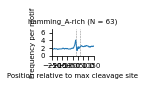

hamming_T-rich    : Peak frequency 6.355 @ -9


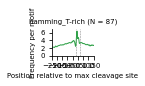

hamming_GTA       : Peak frequency 4.248 @ 27


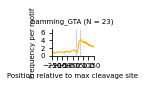

hamming_TAG       : Peak frequency 3.505 @ -34


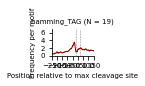

hamming_GTA-TAG   : Peak frequency 2.691 @ 26


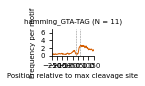

In [13]:
region = (-250,150)
smoothing = 10

ylim_hamming = (0,10)
ylim_family  = (0,7)
ylim_cluster = (0,40)

for motfam,motdict in mfam_importance[species][modeltype][config].items():
    
    if any([(f"_d{d}" in motfam) for d in [0,1,2,3]]):
        continue
        
    try:
        
        if (motfam.startswith('hamming_')):
            motcolor = family_cmap[motfam.replace("hamming_", "")]
        elif (motfam.startswith('pattern_')):
            motcolor = 'black'
        
        fig,ax = plt.subplots(1,1, figsize = (0.75,0.5))

        xs           = motdict['data']['xs']
        means        = motdict['data']['freqs'] / len(motdict['motifs'])
        means_smooth = pd.Series(means).rolling(window = smoothing, center = True).mean()

        sns.lineplot(x = xs, y = means_smooth, color = motcolor, label = motfam, lw = 1, ax = ax)
        print(f"{motfam:18}: Peak frequency {np.nanmax(means_smooth):5.03f} @ {xs[np.nanargmax(means_smooth)]:.0f}")

        ax.axhline(y =   0, linewidth = 0.5, linestyle = 'dashed', color = 'gray', zorder = 0)
        ax.axvline(x = -20, linewidth = 0.5, linestyle = 'dashed', color = 'gray', zorder = 0)
        ax.axvline(x =  20, linewidth = 0.5, linestyle = 'dashed', color = 'gray', zorder = 0)

        ax.set_xlim(region)
        ax.xaxis.set_major_locator(MultipleLocator(50))
        ax.set_xlabel("Position relative to max cleavage site")

        ax.set_ylim(ylim_hamming if ("_d" in motfam) else ylim_family if ("hamming_" in motfam) else ylim_cluster)
        ax.yaxis.set_major_locator(MultipleLocator(2))
        ax.set_ylabel("Frequency per motif")

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        ax.set_title(f"{motfam} (N = {len(motdict['motifs'])})", fontsize = 7)
        ax.get_legend().remove()

        plt.savefig(os.path.join(OUTDIR, f'family_importance.{motfam.replace("/","")}.frequency.svg'), format = 'svg', dpi = 600, transparent = True)
        plt.show()

    except KeyError:
        plt.close()
        continue
    

hamming_A-rich    : Peak per-site 4.101 @ -23


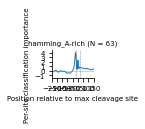

hamming_T-rich    : Peak per-site 3.577 @ 0


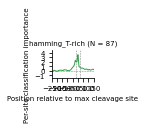

hamming_GTA       : Peak per-site 2.535 @ 1


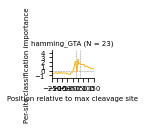

hamming_TAG       : Peak per-site 2.517 @ -29


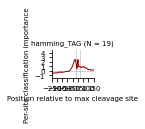

hamming_GTA-TAG   : Peak per-site 2.594 @ -25


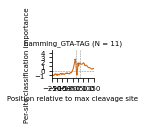

In [14]:
region = (-250,150)
smoothing = 10

for motfam,motdict in mfam_importance[species][modeltype][config].items():
    
    if any([(f"_d{d}" in motfam) for d in [0,1,2,3]]):
        continue
        
    try:
        
        if (motfam.startswith('hamming_')):
            motcolor = family_cmap[motfam.replace("hamming_", "")]
        elif (motfam.startswith('pattern_')):
            motcolor = 'black'
            
        fig,ax = plt.subplots(1,1, figsize = (0.75,0.5))

        xs           = motdict['data']['xs']
        means        = -1*motdict['data']['means']
        means_smooth = pd.Series(means).rolling(window = smoothing, center = True).mean()

        sns.lineplot(x = xs, y = means_smooth, color = motcolor, label = motfam, lw = 1, ax = ax)
        print(f"{motfam:18}: Peak per-site {np.nanmax(means_smooth):5.03f} @ {xs[np.nanargmax(means_smooth)]:.0f}")

        ax.axhline(y =   0, linewidth = 0.5, linestyle = 'dashed', color = 'gray', zorder = 0)
        ax.axvline(x = -20, linewidth = 0.5, linestyle = 'dashed', color = 'gray', zorder = 0)
        ax.axvline(x =  20, linewidth = 0.5, linestyle = 'dashed', color = 'gray', zorder = 0)

        ax.set_xlim(region)
        ax.xaxis.set_major_locator(MultipleLocator(50))
        ax.set_xlabel("Position relative to max cleavage site")

        ax.set_ylim((-1.5,4.5))
        ax.yaxis.set_major_locator(MultipleLocator(1))
        ax.set_ylabel("Per-site classification importance")

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        ax.set_title(f"{motfam} (N = {len(motdict['motifs'])})", fontsize = 7)
        ax.get_legend().remove()

        plt.savefig(os.path.join(OUTDIR, f'family_importance.{motfam.replace("/","")}.per_site.svg'), format = 'svg', dpi = 600, transparent = True)
        plt.show()

    except KeyError:
        plt.close()
        continue


#### Family importance profiles using motif-normalized sum importance scores

hamming_A-rich      : Peak sum-norm  67.308 @ -22
hamming_T-rich      : Peak sum-norm  61.163 @ 0
hamming_GTA         : Peak sum-norm  28.011 @ 21
hamming_TAG         : Peak sum-norm  32.475 @ -33
hamming_GTA-TAG     : Peak sum-norm  18.641 @ 55


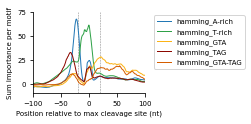

In [15]:
fig,ax = plt.subplots(1,1, figsize = (2,1.5))

region = (-100,100)
smoothing = 10

for motfam,motdict in mfam_importance[species][modeltype][config].items():
    
    if ("_d" in motfam) or ("pattern_" in motfam) or ("controls" in motfam):
        continue
    
    xs           = motdict['data']['xs']
    means        = -1*motdict['data']['means_weights'] / len(motdict['motifs'])
    means_smooth = pd.Series(means).rolling(window = smoothing, center = True).mean()
    print(f"{motfam:20}: Peak sum-norm {np.nanmax(means_smooth):7.03f} @ {xs[np.nanargmax(means_smooth)]:.0f}")

    sns.lineplot(x = xs, y = means_smooth, color = family_cmap[motfam.replace("hamming_","")], label = motfam, lw = 1, ax = ax)

ax.axvline(x = -20, linewidth = 0.5, linestyle = 'dashed', color = 'gray', zorder = 0)
ax.axvline(x = 20,  linewidth = 0.5, linestyle = 'dashed', color = 'gray', zorder = 0)

ax.set_xlim(region)
ax.xaxis.set_major_locator(MultipleLocator(50))

ax.set_ylim(-10,75)
ax.yaxis.set_major_locator(MultipleLocator(25))
ax.set_ylabel("Sum importance per motif")
ax.set_xlabel("Position relative to max cleavage site (nt)")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(bbox_to_anchor = (1.05,1))

plt.savefig(os.path.join(OUTDIR, 'family_consolidated.sum_norm.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Breakdown of family importance profiles by Hamming distance

hamming_A-rich_d0    : Peak per-site 2.618 @ -23
hamming_A-rich_d1    : Peak per-site 3.442 @ -22
hamming_A-rich_d2    : Peak per-site 4.236 @ -22
hamming_A-rich_d3    : Peak per-site 4.274 @ -23
hamming_T-rich_d0    : Peak per-site 2.645 @ -9
hamming_T-rich_d1    : Peak per-site 3.763 @ 0
hamming_T-rich_d2    : Peak per-site 3.464 @ 0
hamming_GTA_d0       : Peak per-site 2.535 @ 1
hamming_TAG_d0       : Peak per-site 2.517 @ -29
hamming_GTA-TAG_d0   : Peak per-site 2.594 @ -25


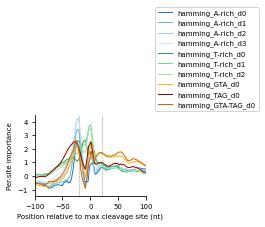

In [16]:
fig,ax = plt.subplots(1,1, figsize = (2,1.5))

region = (-100,100)
smoothing = 10

ylims = (-1.5,4.5)

for motfam,motdict in mfam_importance[species][modeltype][config].items():
    
    if ("_d" not in motfam):
        continue
    
    xs           = motdict['data']['xs']
    means        = -1*motdict['data']['means']
    means_smooth = pd.Series(means).rolling(window = smoothing, center = True).mean()
    print(f"{motfam:21}: Peak per-site {np.nanmax(means_smooth):5.03f} @ {xs[np.nanargmax(means_smooth)]:.0f}")

    sns.lineplot(x = xs, y = means_smooth, color = family_cmap[motfam.replace("hamming_","")], label = motfam, lw = 1, ax = ax)

for x in [-20,20]:
    ax.axvline(x = x, linewidth = 0.5, linestyle = 'dashed', color = 'gray', zorder = 0)

ax.set_xlim(region)
ax.xaxis.set_major_locator(MultipleLocator(50))

ax.set_ylim(ylims)
ax.yaxis.set_major_locator(MultipleLocator(1))

ax.set_ylabel("Per-site importance")
ax.set_xlabel("Position relative to max cleavage site (nt)")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(bbox_to_anchor = (1.05,1))

plt.savefig(os.path.join(OUTDIR, 'family_breakdown.persite.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


hamming_A-rich_d0    : Peak per-site 9.300 @ 233
hamming_A-rich_d1    : Peak per-site 2.977 @ 234
hamming_A-rich_d2    : Peak per-site 4.055 @ -22
hamming_A-rich_d3    : Peak per-site 4.656 @ -23
hamming_T-rich_d0    : Peak per-site 44.100 @ -9
hamming_T-rich_d1    : Peak per-site 11.794 @ -9
hamming_T-rich_d2    : Peak per-site 4.382 @ -8
hamming_GTA_d0       : Peak per-site 4.248 @ 27
hamming_TAG_d0       : Peak per-site 3.505 @ -34
hamming_GTA-TAG_d0   : Peak per-site 2.691 @ 26


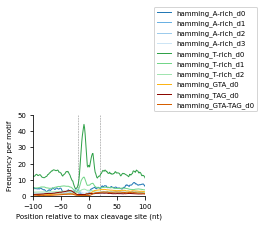

In [17]:
fig,ax = plt.subplots(1,1, figsize = (2,1.5))

region = (-100,100)
smoothing = 10

ylims = (0,None)

for motfam,motdict in mfam_importance[species][modeltype][config].items():
    
    if ("_d" not in motfam):
        continue
    
    xs           = motdict['data']['xs']
    means        = motdict['data']['freqs'] / len(motdict['motifs'])
    means_smooth = pd.Series(means).rolling(window = smoothing, center = True).mean()
    print(f"{motfam:21}: Peak per-site {np.nanmax(means_smooth):5.03f} @ {xs[np.nanargmax(means_smooth)]:.0f}")

    sns.lineplot(x = xs, y = means_smooth, color = family_cmap[motfam.replace("hamming_","")], label = motfam, lw = 1, ax = ax)

for x in [-20,20]:
    ax.axvline(x = x, linewidth = 0.5, linestyle = 'dashed', color = 'gray', zorder = 0)

ax.set_xlim(region)
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.set_xlabel("Position relative to max cleavage site (nt)")

ax.set_ylim(0,50)
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.set_ylabel("Frequency per motif")


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(bbox_to_anchor = (1.05,1))

plt.savefig(os.path.join(OUTDIR, 'family_breakdown.frequency.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


## Top individual motifs in each region

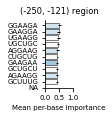

      motif  frequency     score   conf_lo   conf_hi     family  error_lo
89   GGAAGA      112.0  0.502531  0.559719  0.445342  A-rich_d3  0.057188
83   GAAGGA      138.0  0.486132  0.530673  0.441591  A-rich_d3  0.044541
145  UGAAGG      140.0  0.477771  0.519718  0.435825      Other  0.041947
148  UGCUGC      228.0  0.457486  0.485518  0.429454      Other  0.028032
36   AGGAAG      111.0  0.440308  0.498864  0.381752  A-rich_d3  0.058556
70   CUGCUG      279.0  0.439189  0.460525  0.417852      Other  0.021337
81   GAAGAA      391.0  0.434304  0.465954  0.402653  A-rich_d2  0.031651
85   GCUGCU      289.0  0.430974  0.452956  0.408993      Other  0.021981
35   AGAAGG      191.0  0.424896  0.464124  0.385668  A-rich_d3  0.039228
86   GCUUUG      175.0  0.424495  0.455346  0.393643      Other  0.030852
0.5597185874871564


In [18]:
motifs.region_barplot(OUTDIR, mot_dis_dir, spom_definitions['distance'][6]['hamming'], sigmots, 
                      (-250,-121), "mean", 95, method = "hamming", minfreq = int(0.01 * gold_sites),
                      topn = 10, palette = family_cmap, 
                      xlim = (0,1), xtickint = 0.5, verbose = True
                     )


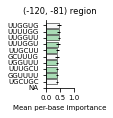

      motif  frequency     score   conf_lo   conf_hi     family  error_lo
188  UUGGUG       35.0  0.482263  0.552732  0.411795      Other  0.070468
224  UUUUGG      110.0  0.462023  0.504794  0.419252  T-rich_d2  0.042771
189  UUGGUU      107.0  0.461806  0.494775  0.428837  T-rich_d2  0.032969
213  UUUGGU       77.0  0.439039  0.495212  0.382866  T-rich_d2  0.056173
186  UUGCUU       84.0  0.419759  0.463366  0.376151  T-rich_d2  0.043607
86   GCUUUG       34.0  0.413010  0.493870  0.332149      Other  0.080861
152  UGGUUU       83.0  0.412636  0.458344  0.366927  T-rich_d2  0.045708
211  UUUGCU       91.0  0.412472  0.454307  0.370638  T-rich_d2  0.041834
90   GGUUUU       91.0  0.402741  0.437311  0.368171  T-rich_d2  0.034570
148  UGCUGC       51.0  0.391874  0.430269  0.353479      Other  0.038395
0.5527317749553193


In [19]:
motifs.region_barplot(OUTDIR, mot_dis_dir, spom_definitions['distance'][6]['hamming'], sigmots, 
                      (-120,-81), "mean", 95, method = "hamming", minfreq = int(0.01 * gold_sites),
                      topn = 10, palette = family_cmap, 
                      xlim = (0,1), xtickint = 0.5, verbose = True
                     )


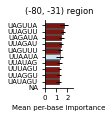

      motif  frequency     score   conf_lo   conf_hi     family  error_lo
123  UAGUUA       86.0  1.697468  2.059290  1.335645     TAG_d0  0.361822
173  UUAGUU      183.0  1.598354  1.767721  1.428987     TAG_d0  0.169367
117  UAGAUA      102.0  1.455347  1.695534  1.215159     TAG_d0  0.240188
170  UUAGAU      133.0  1.432431  1.632911  1.231952     TAG_d0  0.200479
124  UAGUUU      190.0  1.349594  1.505046  1.194142     TAG_d0  0.155452
166  UUAAUA       91.0  1.316212  1.644540  0.987885  A-rich_d3  0.328328
174  UUAUAG      102.0  1.294843  1.496497  1.093189     TAG_d0  0.201654
201  UUUAGU      163.0  1.291643  1.439882  1.143405     TAG_d0  0.148238
171  UUAGGU      113.0  1.249575  1.396913  1.102237     TAG_d0  0.147338
127  UAUAGU       74.0  1.217318  1.465060  0.969576     TAG_d0  0.247742
2.059289558159935


In [20]:
motifs.region_barplot(OUTDIR, mot_dis_dir, spom_definitions['distance'][6]['hamming'], sigmots, 
                      (-80,-31), "mean", 95, method = "hamming", minfreq = int(0.01 * gold_sites),
                      topn = 10, palette = family_cmap, 
                      xlim = (0,2.5), xtickint = 1, verbose = True
                     )


/home/esk863/.conda/envs/tf-train/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:135: RuntimeWarning: invalid value encountered in double_scalars
  return self.sum / self.sum_weights
/home/esk863/.conda/envs/tf-train/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:182: RuntimeWarning: invalid value encountered in double_scalars
  return self.sumsquares / (self.sum_weights - self.ddof)
/home/esk863/.conda/envs/tf-train/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:228: RuntimeWarning: invalid value encountered in sqrt
  return std / np.sqrt(self.sum_weights - 1)
/home/esk863/.conda/envs/tf-train/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:228: RuntimeWarning: invalid value encountered in double_scalars
  return std / np.sqrt(self.sum_weights - 1)


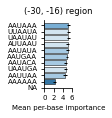

    motif  frequency     score   conf_lo   conf_hi     family  error_lo
0  AAUAAA      103.0  5.197456  5.560169  4.834743  A-rich_d1  0.362713
1  UUAAUA      130.0  5.145078  5.469594  4.820562  A-rich_d3  0.324516
2  UAAUAU       99.0  5.121532  5.468154  4.774910  A-rich_d3  0.346622
3  AUUAAU      128.0  5.024644  5.375626  4.673662  A-rich_d3  0.350982
4  AAUAUA      126.0  5.003125  5.362692  4.643557  A-rich_d2  0.359567
5  AAUGAA      136.0  4.886681  5.189903  4.583459  A-rich_d2  0.303222
6  AAUACA       93.0  4.616605  4.950379  4.282830  A-rich_d2  0.333774
7  UAAUGA       94.0  4.557070  4.909458  4.204682  A-rich_d3  0.352388
8  AAUUAA       77.0  4.468715  4.969058  3.968372  A-rich_d2  0.500343
9  AAAAAA       58.0  2.248774  2.595590  1.901958  A-rich_d0  0.346816
5.560168569713604


In [21]:
motifs.region_barplot(OUTDIR, mot_dis_dir, spom_definitions['distance'][6]['hamming'], sigmots, 
                      (-30,-16), "mean", 95, method = "hamming", minfreq = int(0.01 * gold_sites),
                      topn = 10, displaylist = ['AAAAAA'], palette = family_cmap, 
                      xlim = (0,6), xtickint = 2, verbose = True
                     )


/home/esk863/.conda/envs/tf-train/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:228: RuntimeWarning: invalid value encountered in double_scalars
  return std / np.sqrt(self.sum_weights - 1)
/home/esk863/.conda/envs/tf-train/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:135: RuntimeWarning: invalid value encountered in double_scalars
  return self.sum / self.sum_weights
/home/esk863/.conda/envs/tf-train/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:182: RuntimeWarning: invalid value encountered in double_scalars
  return self.sumsquares / (self.sum_weights - self.ddof)
/home/esk863/.conda/envs/tf-train/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:228: RuntimeWarning: invalid value encountered in sqrt
  return std / np.sqrt(self.sum_weights - 1)


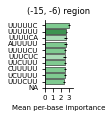

      motif  frequency     score   conf_lo   conf_hi     family  error_lo
227  UUUUUC      132.0  3.042800  3.193855  2.891744  T-rich_d1  0.151056
229  UUUUUU      419.0  2.678921  2.750852  2.606989  T-rich_d0  0.071931
220  UUUUCA       73.0  2.597871  2.812704  2.383039  T-rich_d2  0.214832
62   AUUUUU      197.0  2.589325  2.730945  2.447706  T-rich_d1  0.141620
221  UUUUCU      102.0  2.537163  2.660670  2.413656  T-rich_d1  0.123507
207  UUUCUC       48.0  2.490535  2.697289  2.283782  T-rich_d2  0.206753
182  UUCUUU       94.0  2.477715  2.617743  2.337686  T-rich_d1  0.140029
78   CUUUUU      117.0  2.468976  2.602472  2.335481  T-rich_d1  0.133496
143  UCUUUU      100.0  2.459136  2.583955  2.334317  T-rich_d1  0.124819
208  UUUCUU       94.0  2.423032  2.543446  2.302618  T-rich_d1  0.120414
3.1938551412668414


In [22]:
motifs.region_barplot(OUTDIR, mot_dis_dir, spom_definitions['distance'][6]['hamming'], sigmots, 
                      (-15,-6), "mean", 95, method = "hamming", minfreq = int(0.01 * gold_sites),
                      topn = 10, palette = family_cmap, 
                      xlim = (0,3.5), xtickint = 1, verbose = True
                     )


/home/esk863/.conda/envs/tf-train/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:135: RuntimeWarning: invalid value encountered in double_scalars
  return self.sum / self.sum_weights
/home/esk863/.conda/envs/tf-train/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:182: RuntimeWarning: invalid value encountered in double_scalars
  return self.sumsquares / (self.sum_weights - self.ddof)
/home/esk863/.conda/envs/tf-train/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:228: RuntimeWarning: invalid value encountered in sqrt
  return std / np.sqrt(self.sum_weights - 1)
/home/esk863/.conda/envs/tf-train/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:228: RuntimeWarning: invalid value encountered in double_scalars
  return std / np.sqrt(self.sum_weights - 1)


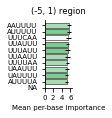

      motif  frequency     score   conf_lo   conf_hi     family  error_lo
31   AAUUUU       63.0  5.643888  6.075585  5.212192  T-rich_d2  0.431697
62   AUUUUU       72.0  5.603182  6.053422  5.152943  T-rich_d1  0.450240
205  UUUCAA       26.0  5.484951  6.040612  4.929291      Other  0.555661
177  UUAUUU       88.0  5.404149  5.761681  5.046617  T-rich_d1  0.357532
204  UUUAUU       60.0  5.342853  5.831199  4.854507  T-rich_d1  0.488346
168  UUAAUU       57.0  5.305376  5.885721  4.725030  T-rich_d2  0.580345
216  UUUUAA       55.0  5.277443  5.601763  4.953124  T-rich_d2  0.324319
115  UAAUUU       57.0  5.203241  5.706703  4.699779  T-rich_d2  0.503462
137  UAUUUU       76.0  5.133770  5.490651  4.776890  T-rich_d1  0.356880
59   AUUUUA       46.0  5.111525  5.441401  4.781650  T-rich_d2  0.329876
6.075585445404289


In [23]:
motifs.region_barplot(OUTDIR, mot_dis_dir, spom_definitions['distance'][6]['hamming'], sigmots, 
                      (-5,1), "mean", 95, method = "hamming", minfreq = int(0.01 * gold_sites),
                      topn = 10, palette = family_cmap, 
                      xlim = (0,6.5), xtickint = 2, verbose = True
                     )


/home/esk863/.conda/envs/tf-train/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:228: RuntimeWarning: invalid value encountered in double_scalars
  return std / np.sqrt(self.sum_weights - 1)
/home/esk863/.conda/envs/tf-train/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:135: RuntimeWarning: invalid value encountered in double_scalars
  return self.sum / self.sum_weights
/home/esk863/.conda/envs/tf-train/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:182: RuntimeWarning: invalid value encountered in double_scalars
  return self.sumsquares / (self.sum_weights - self.ddof)
/home/esk863/.conda/envs/tf-train/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:228: RuntimeWarning: invalid value encountered in sqrt
  return std / np.sqrt(self.sum_weights - 1)


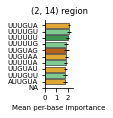

      motif  frequency     score   conf_lo   conf_hi      family  error_lo
214  UUUGUA       90.0  2.132958  2.265675  2.000240      GTA_d0  0.132718
225  UUUUGU      119.0  2.102451  2.275993  1.928909   T-rich_d1  0.173542
229  UUUUUU      299.0  2.005150  2.112099  1.898202   T-rich_d0  0.106948
228  UUUUUG      121.0  1.888986  2.060377  1.717594   T-rich_d1  0.171392
191  UUGUAG       29.0  1.881111  2.094035  1.668188  GTA-TAG_d0  0.212923
190  UUGUAA       61.0  1.879623  2.011493  1.747753      GTA_d0  0.131870
226  UUUUUA      122.0  1.833896  1.988332  1.679460   T-rich_d1  0.154436
192  UUGUAU       70.0  1.815420  1.964305  1.666534      GTA_d0  0.148886
215  UUUGUU       90.0  1.767145  1.938126  1.596164   T-rich_d1  0.170981
54   AUUGUA       50.0  1.743220  1.924182  1.562257      GTA_d0  0.180963
2.275992634149941


In [24]:
motifs.region_barplot(OUTDIR, mot_dis_dir, spom_definitions['distance'][6]['hamming'], sigmots, 
                      (2,14), "mean", 95, method = "hamming", minfreq = int(0.01 * gold_sites),
                      topn = 10, palette = family_cmap, 
                      xlim = (0,2.5), xtickint = 1, verbose = True
                     )


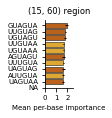

      motif  frequency     score   conf_lo   conf_hi      family  error_lo
95   GUAGUA       82.0  1.964518  2.098477  1.830560  GTA-TAG_d0  0.133958
191  UUGUAG      166.0  1.829590  1.900976  1.758204  GTA-TAG_d0  0.071386
157  UGUAGU      147.0  1.787635  1.868716  1.706555  GTA-TAG_d0  0.081081
190  UUGUAA      292.0  1.685018  1.729096  1.640939      GTA_d0  0.044079
153  UGUAAA      270.0  1.683935  1.738337  1.629534      GTA_d0  0.054402
38   AGUAGU      103.0  1.666280  1.779182  1.553377  GTA-TAG_d0  0.112902
214  UUUGUA      348.0  1.642903  1.696713  1.589094      GTA_d0  0.053809
121  UAGUAG       85.0  1.635970  1.761993  1.509948  GTA-TAG_d0  0.126022
54   AUUGUA      224.0  1.618441  1.684928  1.551954      GTA_d0  0.066487
120  UAGUAA      136.0  1.602475  1.695993  1.508956  GTA-TAG_d0  0.093519
2.098476554486169


In [25]:
motifs.region_barplot(OUTDIR, mot_dis_dir, spom_definitions['distance'][6]['hamming'], sigmots, 
                      (15,60), "mean", 95, method = "hamming", minfreq = int(0.01 * gold_sites),
                      topn = 10, palette = family_cmap, 
                      xlim = (0,2.5), xtickint = 1, verbose = True
                     )


## Motif crosstalk

In [26]:
gold_motifs = {
    'UU' : {
        'motifs' : mfam_importance[species][modeltype][config]['hamming_T-rich']['motifs'],
        'region' : (-90,-31),
    },
    'PAS' : {
        'motifs' : mfam_importance[species][modeltype][config]['hamming_A-rich']['motifs'],
        'region' : (-30,-16),
    },
    'UF' : {
        'motifs' : mfam_importance[species][modeltype][config]['hamming_T-rich']['motifs'],
        'region' : (-15,-6),
    },
    'UAG' : {
        'motifs' : mfam_importance[species][modeltype][config]['hamming_TAG']['motifs'] + mfam_importance[species][modeltype][config]['hamming_GTA-TAG']['motifs'],
        'region' : (-90,-31),
    },
}


In [27]:
gold_data = pd.read_csv(os.path.join(RESOURCES, "polyaclassifier_external_data_predictions.spom_golden_dist5.pred_by_spom_bagging3models.txt"), sep = "\t").drop(columns = ['sequence2'])

gold_data['label']      = gold_data.apply(lambda row : f'{row.name:06d}:{row.chrom}:{row.start}:{row.strand}', axis = 1)
gold_data['sequence']   = gold_data['sequence'].apply(lambda x : x[int((len(x)-500)/2):int((len(x)+500)/2)].upper())
gold_data['idx_ctrclv'] = 250

print(gold_data.shape)


(2492, 15)


In [28]:
## Find locations of important elements surrounding polyA sites
gold_data['idxs_PAS'] = gold_data['sequence'].apply(lambda x : motifs.count_motifs(x, gold_motifs['PAS']['motifs'], overlapping = False, preference = 'max', method = 'equal', count_only = False, index_only = True))
gold_data['idxs_UAG'] = gold_data['sequence'].apply(lambda x : motifs.count_motifs(x, gold_motifs['UAG']['motifs'], overlapping = False, preference = 'max', method = 'equal', count_only = False, index_only = True))
gold_data['idxs_UU']  = gold_data['sequence'].apply(lambda x : motifs.count_motifs(x, gold_motifs['UU']['motifs'],  overlapping = False, preference = 'max', method = 'equal', count_only = False, index_only = True))
gold_data['idxs_UF']  = gold_data['sequence'].apply(lambda x : motifs.count_motifs(x, gold_motifs['UF']['motifs'],  overlapping = False, preference = 'min', method = 'equal', count_only = False, index_only = True))


In [29]:
## Identify last PAS
gold_data['idx_PAS'] = gold_data.apply(lambda row : motifs.select_motifs(row['idxs_PAS'], index = 'last', region = gold_motifs['PAS']['region'], relative = True, maxclv = row['idx_ctrclv']), axis = 1)
gold_data['pos_PAS'] = gold_data['idx_PAS'] - gold_data['idx_ctrclv']


In [30]:
## Find first U-rich element upstream of the selected PAS
# gold_data['idx_UU'] = gold_data.apply(lambda row : motifs.select_motifs(row['idxs_UU'], index = 'last', region = (-90,row['pos_PAS']), relative = True, maxclv = row['idx_ctrclv']), axis = 1)
gold_data['idx_UU'] = gold_data.apply(lambda row : motifs.select_motifs(row['idxs_UU'], index = 'last', region = gold_motifs['UU']['region'], relative = True, maxclv = row['idx_ctrclv']), axis = 1)


In [31]:
## Find first UAG-rich element upstream of the selected PAS
# gold_data['idx_UAG'] = gold_data.apply(lambda row : motifs.select_motifs(row['idxs_UAG'], index = 'last', region = (-90,row['pos_PAS']), relative = True, maxclv = row['idx_ctrclv']), axis = 1)
gold_data['idx_UAG'] = gold_data.apply(lambda row : motifs.select_motifs(row['idxs_UAG'], index = 'last', region = gold_motifs['UAG']['region'], relative = True, maxclv = row['idx_ctrclv']), axis = 1)


In [32]:
## Find the first U-rich element downstream of the selected PAS
# gold_data['idx_UF'] = gold_data.apply(lambda row : motifs.select_motifs(row['idxs_UF'], index = 'first', region = (row['pos_PAS'],-6), relative = True, maxclv = row['idx_ctrclv']), axis = 1)
gold_data['idx_UF'] = gold_data.apply(lambda row : motifs.select_motifs(row['idxs_UF'], index = 'first', region = gold_motifs['UF']['region'], relative = True, maxclv = row['idx_ctrclv']), axis = 1)


### Analysis of motif crosstalk between degenerate *cis*-elements

In [33]:
gold_data['testKey'] = gold_data.apply(lambda row: f'{row.name:06d}_{row["chrom"]}_{row["start"]}_{row["strand"]}', axis = 1)

gold_data['testKey_UAG'] = gold_data.apply(lambda row: f'{row["testKey"]}|{row["idx_UAG"]-row["idx_ctrclv"]}', axis = 1)
gold_data['testKey_UU']  = gold_data.apply(lambda row: f'{row["testKey"]}|{row["idx_UU"] -row["idx_ctrclv"]}', axis = 1)
gold_data['testKey_PAS'] = gold_data.apply(lambda row: f'{row["testKey"]}|{row["idx_PAS"]-row["idx_ctrclv"]}', axis = 1)
gold_data['testKey_UF']  = gold_data.apply(lambda row: f'{row["testKey"]}|{row["idx_UF"] -row["idx_ctrclv"]}', axis = 1)

gold_pas_uag = gold_data.loc[~gold_data['idx_PAS'].isna() & ~gold_data['idx_UAG'].isna()].copy()
gold_pas_uu  = gold_data.loc[~gold_data['idx_PAS'].isna() & ~gold_data['idx_UU'].isna()].copy()
gold_pas_uf  = gold_data.loc[~gold_data['idx_PAS'].isna() & ~gold_data['idx_UF'].isna()].copy()

gold_pas_uag['dist_PAS_UAG'] = gold_pas_uag['idx_UAG'] - gold_pas_uag['idx_PAS']
gold_pas_uu['dist_PAS_UU']   = gold_pas_uu['idx_UU']   - gold_pas_uu['idx_PAS']
gold_pas_uf['dist_PAS_UF']   = gold_pas_uf['idx_UF']   - gold_pas_uf['idx_PAS']

print(gold_data.shape)
print("PAS & UAG:", gold_pas_uag.shape)
print("PAS & UU:",  gold_pas_uu.shape)
print("PAS & UF:",  gold_pas_uf.shape)


(2492, 29)
PAS & UAG: (836, 30)
PAS & UU: (1680, 30)
PAS & UF: (1036, 30)


In [34]:
single_panel_width_row1 = 0.85
single_panel_width_row2 = 1.00
double_panel_width = (single_panel_width_row1 * 2) + 0.5
single_panel_height = 1
upper_lower_panel_ratios = [2, 1]

pas_mfams   = ['hamming_A-rich']
u_mfams     = ['hamming_T-rich']
uag_mfams   = ['hamming_TAG','hamming_GTA-TAG']


#### Crosstalk between the PAS and upstream U-rich elements

In [35]:
fd_pas_uu = motifs.relative_position_motif_to_motif_importance(pas_mfams, u_mfams, 'PAS','UU',
                                                              'dist_PAS_UU', 'idx_PAS', 'idx_UU', 
                                                              'up_PAS', 
                                                              mfam_importance[species][modeltype][config], 
                                                              gold_pas_uu)


Beginning Motif-Motif distance compilation for: ['hamming_A-rich'] ['hamming_T-rich']
up_PAS dist_PAS_UU idx_PAS idx_UU
DISTANCE RANGE: -74 -1
-74	Freq =	0	1
-73	Freq =	1	1
-72	Freq =	1	1
-71	Freq =	3	3
-70	Freq =	2	3
-69	Freq =	2	2
-68	Freq =	1	1
-67	Freq =	3	3
-66	Freq =	2	2
-65	Freq =	1	7
-64	Freq =	2	3
-63	Freq =	3	6
-62	Freq =	6	8
-61	Freq =	3	4
-60	Freq =	2	3
-59	Freq =	5	8
-58	Freq =	2	4
-57	Freq =	10	12
-56	Freq =	7	11
-55	Freq =	5	7
-54	Freq =	5	6
-53	Freq =	13	20
-52	Freq =	7	14
-51	Freq =	4	5
-50	Freq =	11	13
-49	Freq =	10	13
-48	Freq =	5	8
-47	Freq =	6	9
-46	Freq =	6	7
-45	Freq =	12	15
-44	Freq =	14	17
-43	Freq =	9	17
-42	Freq =	7	19
-41	Freq =	12	17
-40	Freq =	11	20
-39	Freq =	9	11
-38	Freq =	9	19
-37	Freq =	10	18
-36	Freq =	12	17
-35	Freq =	12	11
-34	Freq =	10	13
-33	Freq =	20	29
-32	Freq =	23	31
-31	Freq =	20	26
-30	Freq =	14	29
-29	Freq =	22	35
-28	Freq =	23	33
-27	Freq =	18	31
-26	Freq =	22	33
-25	Freq =	27	41
-24	Freq =	24	38
-23	Freq =	30	46
-22	Freq =	33	46
-21	Freq

Beginning frequency and score tabulation using: dist_PAS_UU
Distance range covered: -74 -1
PAS
(-22, 23.0)
(-21, 18.0)
(-20, 22.0)
(-19, 27.0)
(-18, 24.0)
(-17, 30.0)
(-16, 33.0)
(-15, 20.0)
(-14, 33.0)
(-13, 41.0)
(-12, 40.0)
(-11, 40.0)
(-10, 45.0)
(-9, 66.0)
(-8, 32.0)
(-7, 50.0)
(-6, 43.0)
(-5, 37.0)
(-4, 28.0)
(-3, 27.0)
(-2, 19.0)
(-1, 26.0)
(0, 14.0)
(1, 9.0)
(2, 4.0)
(-22, 23.0)
(-21, 18.0)
(-20, 22.0)
(-19, 27.0)
(-18, 24.0)
(-17, 30.0)
(-16, 33.0)
(-15, 20.0)
(-14, 33.0)
(-13, 41.0)
(-12, 40.0)
(-11, 40.0)
(-10, 45.0)
(-9, 66.0)
(-8, 32.0)
(-7, 50.0)
(-6, 43.0)
(-5, 37.0)
(-4, 28.0)
(-3, 27.0)
(-2, 19.0)
(-1, 26.0)
(0, 14.0)
(1, 9.0)
(2, 4.0)
Peak score: 5.328128578040607 @ position 2
Mean score: 3.789595682646131
Peak frequency: 66.0 @ position -9
UU
(-22, 33.0)
(-21, 31.0)
(-20, 33.0)
(-19, 41.0)
(-18, 38.0)
(-17, 46.0)
(-16, 46.0)
(-15, 32.0)
(-14, 50.0)
(-13, 54.0)
(-12, 67.0)
(-11, 65.0)
(-10, 67.0)
(-9, 92.0)
(-8, 57.0)
(-7, 66.0)
(-6, 57.0)
(-5, 59.0)
(-4, 40.0)
(-3, 3

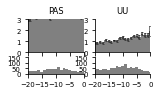

In [36]:
pas_uu_inputs = motifs.tabulate_motif_motif_distances(fd_pas_uu, gold_pas_uu, 'dist_PAS_UU', 'PAS', 'UU', overfill = None, flip = False, return_region = "neg")

motifs.plot_motif_motif_distances('mean', pas_uu_inputs, ['PAS','UU'], 
                                  'distance_pas_uu.positive', OUTDIR, 'gray', 1,
                                  double_panel_width, single_panel_height, upper_lower_panel_ratios,
                                  (-20,0), 5, (0,150), 50, (0,3), 1)


#### Crosstalk between the PAS and upstream UAG-rich elements

In [37]:
fd_pas_uag = motifs.relative_position_motif_to_motif_importance(pas_mfams, uag_mfams, 'PAS','UAG',
                                                              'dist_PAS_UAG', 'idx_PAS', 'idx_UAG', 
                                                              'up_PAS', 
                                                              mfam_importance[species][modeltype][config], 
                                                              gold_pas_uag)


Beginning Motif-Motif distance compilation for: ['hamming_A-rich'] ['hamming_TAG', 'hamming_GTA-TAG']
up_PAS dist_PAS_UAG idx_PAS idx_UAG
DISTANCE RANGE: -72 -3
-72	Freq =	3	3
-71	Freq =	1	1
-70	Freq =	0	3
-69	Freq =	2	3
-68	Freq =	2	5
-67	Freq =	1	2
-66	Freq =	2	2
-65	Freq =	4	4
-64	Freq =	4	5
-63	Freq =	5	6
-62	Freq =	1	4
-61	Freq =	0	4
-60	Freq =	7	9
-59	Freq =	2	8
-58	Freq =	5	5
-57	Freq =	4	5
-56	Freq =	6	9
-55	Freq =	4	8
-54	Freq =	8	16
-53	Freq =	3	5
-52	Freq =	5	6
-51	Freq =	7	7
-50	Freq =	3	12
-49	Freq =	8	13
-48	Freq =	3	7
-47	Freq =	7	13
-46	Freq =	2	5
-45	Freq =	5	9
-44	Freq =	4	7
-43	Freq =	3	9
-42	Freq =	9	10
-41	Freq =	3	4
-40	Freq =	5	6
-39	Freq =	11	15
-38	Freq =	5	6
-37	Freq =	10	13
-36	Freq =	13	15
-35	Freq =	4	5
-34	Freq =	3	9
-33	Freq =	12	16
-32	Freq =	10	14
-31	Freq =	11	18
-30	Freq =	13	15
-29	Freq =	7	13
-28	Freq =	11	20
-27	Freq =	12	21
-26	Freq =	12	16
-25	Freq =	16	22
-24	Freq =	11	17
-23	Freq =	8	15
-22	Freq =	11	18
-21	Freq =	18	25
-20	Freq =	11	18
-19	Fre

Beginning frequency and score tabulation using: dist_PAS_UAG
Distance range covered: -72 -3
PAS
(-22, 11.0)
(-21, 12.0)
(-20, 12.0)
(-19, 16.0)
(-18, 11.0)
(-17, 8.0)
(-16, 11.0)
(-15, 18.0)
(-14, 11.0)
(-13, 21.0)
(-12, 13.0)
(-11, 16.0)
(-10, 16.0)
(-9, 25.0)
(-8, 21.0)
(-7, 14.0)
(-6, 21.0)
(-5, 8.0)
(-4, 12.0)
(-3, 13.0)
(-2, 9.0)
(-1, 9.0)
(0, 3.0)
(1, 6.0)
(2, 1.0)
(3, 3.0)
(-22, 11.0)
(-21, 12.0)
(-20, 12.0)
(-19, 16.0)
(-18, 11.0)
(-17, 8.0)
(-16, 11.0)
(-15, 18.0)
(-14, 11.0)
(-13, 21.0)
(-12, 13.0)
(-11, 16.0)
(-10, 16.0)
(-9, 25.0)
(-8, 21.0)
(-7, 14.0)
(-6, 21.0)
(-5, 8.0)
(-4, 12.0)
(-3, 13.0)
(-2, 9.0)
(-1, 9.0)
(0, 3.0)
(1, 6.0)
(2, 1.0)
(3, 3.0)
Peak score: 5.206703797838244 @ position -7
Mean score: 3.482013793794024
Peak frequency: 25.0 @ position -9
UAG
(-22, 20.0)
(-21, 21.0)
(-20, 16.0)
(-19, 22.0)
(-18, 17.0)
(-17, 15.0)
(-16, 18.0)
(-15, 25.0)
(-14, 18.0)
(-13, 31.0)
(-12, 22.0)
(-11, 24.0)
(-10, 27.0)
(-9, 40.0)
(-8, 27.0)
(-7, 16.0)
(-6, 23.0)
(-5, 14.0)
(-4, 1

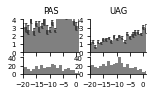

In [38]:
pas_uag_inputs = motifs.tabulate_motif_motif_distances(fd_pas_uag, gold_pas_uag, 'dist_PAS_UAG', 'PAS', 'UAG', overfill = None, flip = False, return_region = "neg")

motifs.plot_motif_motif_distances('mean', pas_uag_inputs, ['PAS','UAG'], 
                                  'distance_pas_uag.positive', OUTDIR, 'gray', 1,
                                  double_panel_width, single_panel_height, upper_lower_panel_ratios,
                                  (-20,1), 5, (0,40), 20, (0,4), 1)


#### Crosstalk between the PAS and downstream CS-flanking U-rich elements

In [39]:
fd_pas_uf = motifs.relative_position_motif_to_motif_importance(pas_mfams, u_mfams, 'PAS','UF',
                                                              'dist_PAS_UF', 'idx_PAS', 'idx_UF', 
                                                              'down_PAS', 
                                                              mfam_importance[species][modeltype][config], 
                                                              gold_pas_uf)


Beginning Motif-Motif distance compilation for: ['hamming_A-rich'] ['hamming_T-rich']
down_PAS dist_PAS_UF idx_PAS idx_UF
DISTANCE RANGE: 1 23
1	Freq =	27	27
2	Freq =	3	3
3	Freq =	6	6
4	Freq =	13	17
5	Freq =	35	49
6	Freq =	29	36
7	Freq =	100	139
8	Freq =	54	81
9	Freq =	52	80
10	Freq =	58	79
11	Freq =	55	81
12	Freq =	37	54
13	Freq =	52	83
14	Freq =	37	50
15	Freq =	31	49
16	Freq =	31	41
17	Freq =	23	31
18	Freq =	15	22
19	Freq =	10	14
20	Freq =	8	12
21	Freq =	5	6
22	Freq =	2	3
23	Freq =	4	4


Beginning frequency and score tabulation using: dist_PAS_UF
Distance range covered: 1 23
PAS
(-2, 13.0)
(-1, 35.0)
(0, 29.0)
(1, 100.0)
(2, 54.0)
(3, 52.0)
(4, 58.0)
(5, 55.0)
(6, 37.0)
(7, 52.0)
(8, 37.0)
(9, 31.0)
(10, 31.0)
(11, 23.0)
(12, 15.0)
(-2, 13.0)
(-1, 35.0)
(0, 29.0)
(1, 100.0)
(2, 54.0)
(3, 52.0)
(4, 58.0)
(5, 55.0)
(6, 37.0)
(7, 52.0)
(8, 37.0)
(9, 31.0)
(10, 31.0)
(11, 23.0)
(12, 15.0)
Peak score: 4.5014725943863185 @ position 10
Mean score: 3.637383587618293
Peak frequency: 100.0 @ position 1
UF
(-2, 17.0)
(-1, 49.0)
(0, 36.0)
(1, 139.0)
(2, 81.0)
(3, 80.0)
(4, 79.0)
(5, 81.0)
(6, 54.0)
(7, 83.0)
(8, 50.0)
(9, 49.0)
(10, 41.0)
(11, 31.0)
(12, 22.0)
(-2, 17.0)
(-1, 49.0)
(0, 36.0)
(1, 139.0)
(2, 81.0)
(3, 80.0)
(4, 79.0)
(5, 81.0)
(6, 54.0)
(7, 83.0)
(8, 50.0)
(9, 49.0)
(10, 41.0)
(11, 31.0)
(12, 22.0)
Peak score: 2.3185327853829185 @ position 0
Mean score: 1.9273431835887536
Peak frequency: 139.0 @ position 1


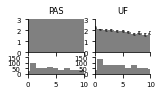

In [40]:
pas_uf_inputs = motifs.tabulate_motif_motif_distances(fd_pas_uf, gold_pas_uf, 'dist_PAS_UF', 'PAS', 'UF', overfill = None, flip = False, return_region = "pos")

motifs.plot_motif_motif_distances('mean', pas_uf_inputs, ['PAS','UF'], 
                                  'distance_pas_uf.positive', OUTDIR, 'gray', 1,
                                  double_panel_width, single_panel_height, upper_lower_panel_ratios,
                                  (0,10), 5, (0,150), 50, (0,3), 1)
